In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import math
from numpy import genfromtxt
import png
from numpy import genfromtxt
from PIL import Image    
from matplotlib.colors import ListedColormap
import scipy.linalg as la
from sklearn.decomposition import PCA
import csv
from sklearn.cluster import KMeans
from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import math
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
import time


# Aesthetics
sns.set_style("whitegrid")

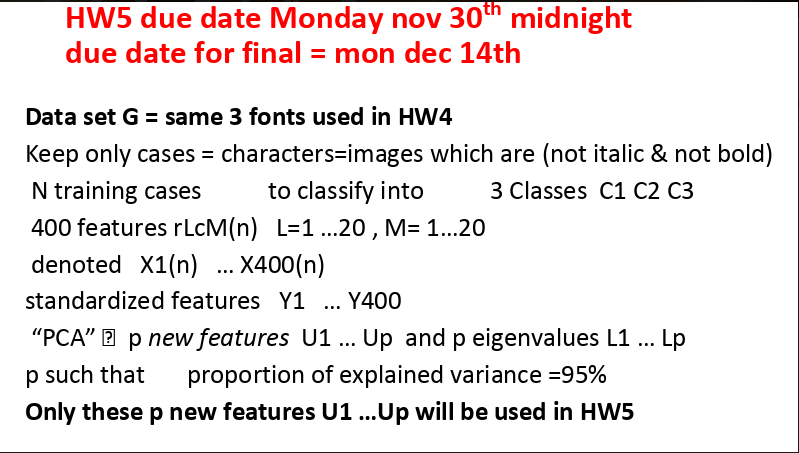

In [2]:
# Read in csv
calibri_df = pd.read_csv('CALIBRI.csv')
courier_df = pd.read_csv('COURIER.csv')
times_df = pd.read_csv('TIMES.csv')

#Display Dataframe
calibri_df.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,CALIBRI,CALIBRI LIGHT,65059,0.4,0,0.0,41,20,7,27,...,255,255,255,86,1,1,1,1,1,1
1,CALIBRI,CALIBRI LIGHT,65058,0.4,0,0.0,40,0,5,20,...,1,1,1,1,1,1,1,1,255,255
2,CALIBRI,CALIBRI LIGHT,65057,0.4,0,0.0,38,20,10,29,...,1,1,1,1,1,1,1,1,97,255
3,CALIBRI,CALIBRI LIGHT,65056,0.4,0,0.0,38,0,6,20,...,1,1,1,1,1,1,1,1,1,1
4,CALIBRI,CALIBRI LIGHT,64260,0.4,0,0.0,38,22,46,46,...,145,255,45,1,1,1,1,1,189,255


In [3]:
# 3 df in a list
dataframes = [calibri_df, courier_df, times_df]

# list unwanted columns
discard = ['fontVariant', 'm_label', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w']

# discard unwanted columns
calibri_df.drop(columns = discard, inplace = True)
courier_df.drop(columns = discard, inplace = True)
times_df.drop(columns = discard, inplace = True)

In [4]:
# keep only normal characters
cl1 = calibri_df[(calibri_df["strength"] == 0.4) & (calibri_df['italic'] == 0)]
cl2 = courier_df[(courier_df['strength'] == 0.4) & (courier_df['italic'] == 0)]
cl3 = times_df[(times_df['strength'] == 0.4) & (times_df['italic'] == 0)]

In [5]:
print(len(cl1), len(cl2), len(cl3))

4768 4262 4805


In [6]:
# stack 3 classes on top of each other
df = pd.concat([cl1, cl2, cl3], ignore_index=True)

In [7]:
# Standardize Data
scaler = StandardScaler()
scaler.fit(df.iloc[:,3:])
sdf = scaler.transform(df.iloc[:,3:])

# Store standarized array into dataframe
sdf = pd.DataFrame(sdf, columns = df.iloc[:,3:].columns)

In [8]:
corr_sdf = sdf.corr()
eigen_vals, eigen_vecs = la.eig(corr_sdf)
eigen_vals = eigen_vals.real

In [9]:
pca = PCA(.95)
pca.fit(sdf)

sdf = pca.transform(sdf)
sdf = pd.DataFrame(sdf)
sdf = sdf.join(df.iloc[:,0])

In [10]:
#Ws = pd.DataFrame(eigen_vecs)
Ls = pd.DataFrame(eigen_vals)

# Question 1

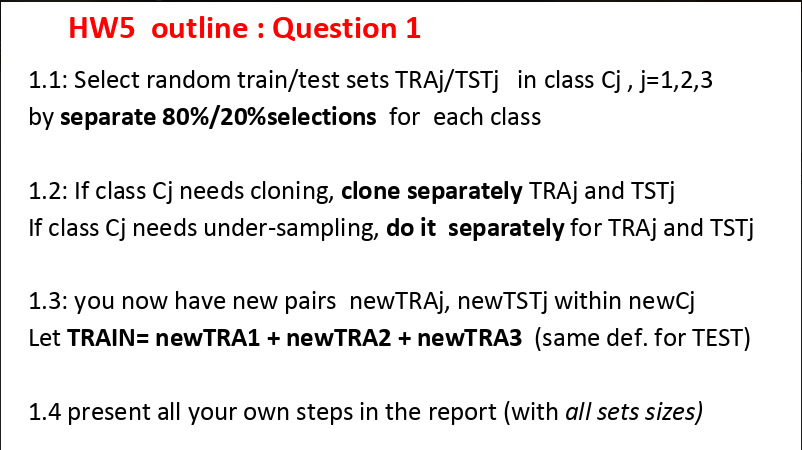

In [11]:
#1.1
cl1_train, cl1_test, font1_train, font1_test = train_test_split(sdf[sdf['font'] == 'CALIBRI'].iloc[:,0:127], sdf[sdf['font'] == 'CALIBRI'].iloc[:,127], test_size=0.2, random_state=0)
cl2_train, cl2_test, font2_train, font2_test = train_test_split(sdf[sdf['font'] == 'COURIER'].iloc[:,0:127], sdf[sdf['font'] == 'COURIER'].iloc[:,127], test_size=0.2, random_state=0)
cl3_train, cl3_test, font3_train, font3_test = train_test_split(sdf[sdf['font'] == 'TIMES'].iloc[:,0:127], sdf[sdf['font'] == 'TIMES'].iloc[:,127], test_size=0.2, random_state=0)

In [12]:
#1.3
X_train = pd.concat([cl1_train, cl2_train, cl3_train])
X_test = pd.concat([cl1_test, cl2_test, cl3_test])
y_train = pd.concat([font1_train, font2_train, font3_train])
y_test = pd.concat([font1_test, font2_test, font3_test])

# Question 2

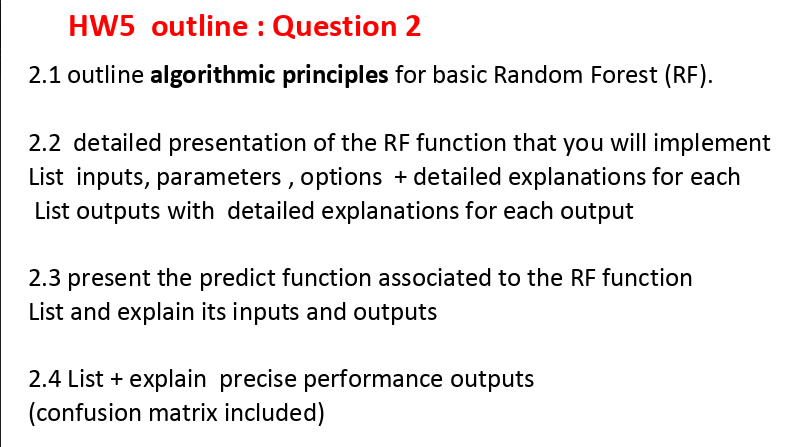

rf = RandomForestClassifier()

params = {'n_estimators':[200],
          'criterion':['entropy', 'gini'], 
          'max_depth':[10, 50, 100, None],
          'max_features': ['sqrt', 'log2'],
          'random_state':[0]}

grid = GridSearchCV(rf, params, cv = 5, scoring='accuracy')
grid.fit(X_train, y_train)

# Question 3

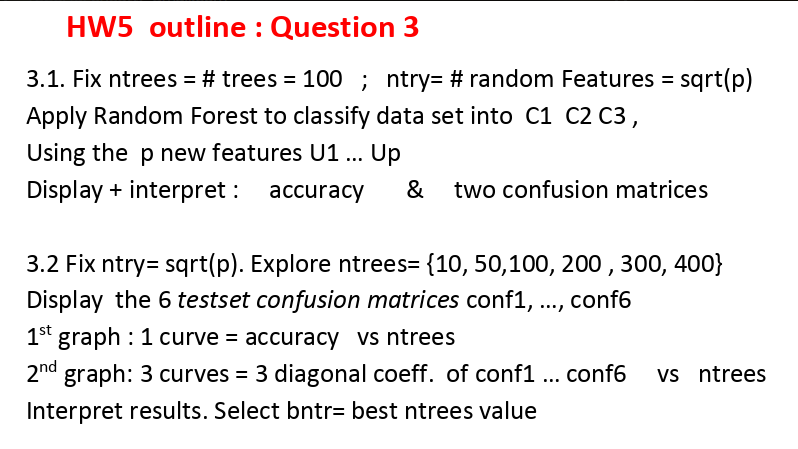

## 3.1

In [13]:
p = pca.n_components_

In [14]:
clf = RandomForestClassifier(n_estimators=100, max_features= round(math.sqrt(p)), random_state=0)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

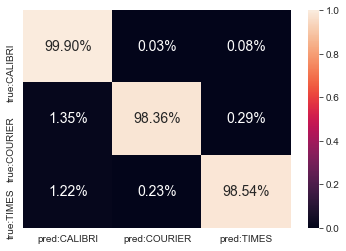

In [15]:
cmtx_a_train = pd.DataFrame(
    confusion_matrix(y_true=y_train,y_pred = y_pred_train, labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'),
    index=['true:CALIBRI', 'true:COURIER', 'true:TIMES'], 
    columns=['pred:CALIBRI', 'pred:COURIER', 'pred:TIMES'])

sns.heatmap(cmtx_a_train, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

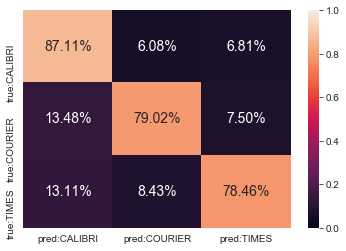

In [16]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_test, labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'),
    index=['true:CALIBRI', 'true:COURIER', 'true:TIMES'], 
    columns=['pred:CALIBRI', 'pred:COURIER', 'pred:TIMES'])

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

## 3.2

In [17]:
y_pred_train = []
y_pred_test = []
n_trees = [10,50,100,200,300,400]

for num in n_trees:
    clf = RandomForestClassifier(n_estimators=num, max_features= round(math.sqrt(p)), random_state=0)
    clf.fit(X_train, y_train)
    y_pred_train.append(clf.predict(X_train))
    y_pred_test.append(clf.predict(X_test))


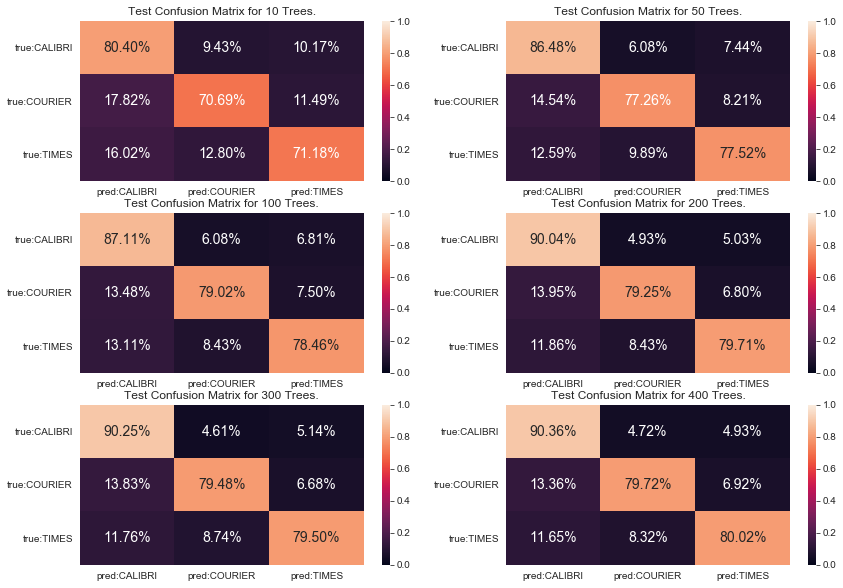

In [18]:
fig = plt.figure(figsize = (14,10))
axes = []

for i in range(0,len(n_trees)):
    axes.append(fig.add_subplot(3, 2, i+1))
    
    cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_test[i], labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'),
    index=['true:CALIBRI', 'true:COURIER', 'true:TIMES'], 
    columns=['pred:CALIBRI', 'pred:COURIER', 'pred:TIMES'])

    sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1, ax=axes[i])
    axes[i].title.set_text('Test Confusion Matrix for '+str(n_trees[i])+' Trees.')

In [19]:
accuracies = []

for i in range(0, len(n_trees)):
    accuracies.append(accuracy_score(y_test, y_pred_test[i]))
    

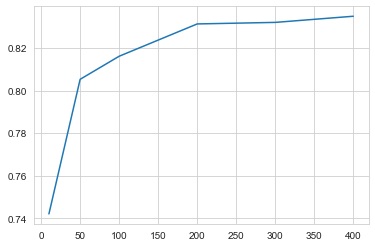

In [20]:
sns.lineplot(x=n_trees, y=accuracies)

In [21]:
calibri_sco = []
courier_sco = []
times_sco = []


for i in range(0,len(n_trees)):
    calibri_sco.append(np.diagonal(confusion_matrix(y_true=y_test,y_pred = y_pred_test[i], labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'))[0])
    courier_sco.append(np.diagonal(confusion_matrix(y_true=y_test,y_pred = y_pred_test[i], labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'))[1])
    times_sco.append(np.diagonal(confusion_matrix(y_true=y_test,y_pred = y_pred_test[i], labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'))[2])

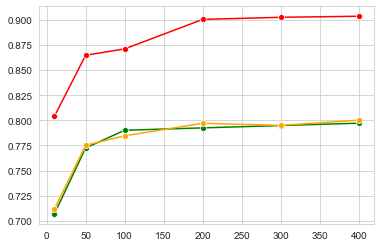

In [22]:
sns.lineplot(x=n_trees,y=calibri_sco, color = 'red', marker = 'o')
sns.lineplot(x=n_trees,y=courier_sco, color = 'green', marker = 'o')
sns.lineplot(x=n_trees,y=times_sco, color = 'orange', marker = 'o')


# Question 4

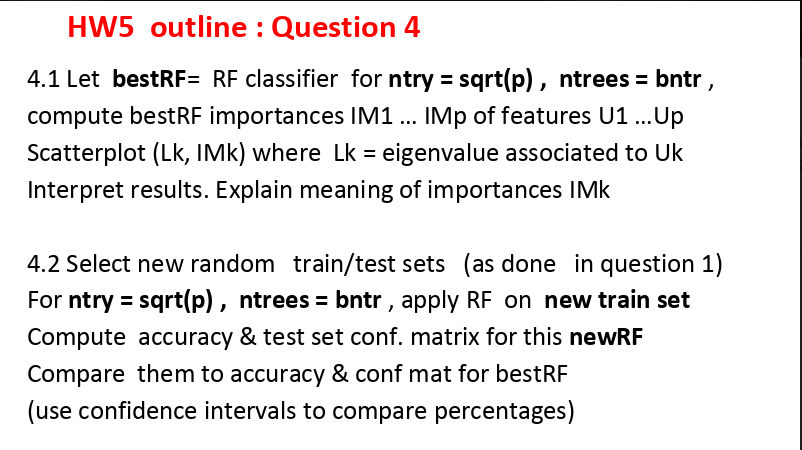

## 4.1

In [23]:
bestRF = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
bestRF.fit(X_train, y_train)
y_pred_best = bestRF.predict(X_test)

In [24]:
eigen_vals = eigen_vals.real

(0.004, 0.04)

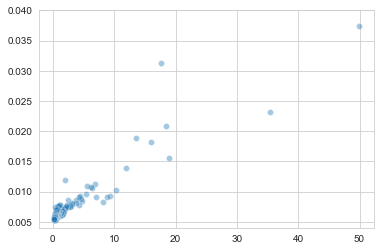

In [25]:
sns.scatterplot(x = eigen_vals[:p], y =bestRF.feature_importances_, alpha = .4)
plt.ylim(0.004,.04)

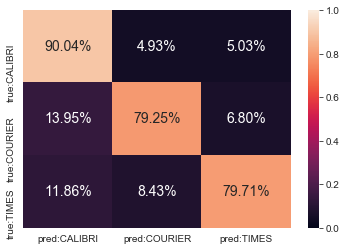

In [26]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_best, labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'),
    index=['true:CALIBRI', 'true:COURIER', 'true:TIMES'], 
    columns=['pred:CALIBRI', 'pred:COURIER', 'pred:TIMES'])

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [27]:
N = len(y_test[y_test == 'CALIBRI'])
p_N = np.diagonal(confusion_matrix(y_true = y_test, y_pred = y_pred_best))[0] / N
sigma = math.sqrt(((p_N * (1 - p_N)) / N))
stats.norm.interval(alpha = 0.95, loc=p_N, scale=sigma)

(0.8814179610172408, 0.9194206134062393)

In [28]:
p_N = sum(np.diagonal(confusion_matrix(y_true = y_test, y_pred = y_pred_best))) / len(y_test)
N = len(y_test)
sigma = math.sqrt(((p_N * (1 - p_N)) / N))
stats.norm.interval(alpha = 0.95, loc=p_N, scale=sigma)

(0.8173347939400968, 0.8452374603951633)

## 4.2

In [29]:
cl1_train, cl1_test, font1_train, font1_test = train_test_split(sdf[sdf['font'] == 'CALIBRI'].iloc[:,0:127], sdf[sdf['font'] == 'CALIBRI'].iloc[:,127], test_size=0.2, random_state=1)
cl2_train, cl2_test, font2_train, font2_test = train_test_split(sdf[sdf['font'] == 'COURIER'].iloc[:,0:127], sdf[sdf['font'] == 'COURIER'].iloc[:,127], test_size=0.2, random_state=1)
cl3_train, cl3_test, font3_train, font3_test = train_test_split(sdf[sdf['font'] == 'TIMES'].iloc[:,0:127], sdf[sdf['font'] == 'TIMES'].iloc[:,127], test_size=0.2, random_state=1)

X_train_n = pd.concat([cl1_train, cl2_train, cl3_train])
X_test_n = pd.concat([cl1_test, cl2_test, cl3_test])
y_train_n = pd.concat([font1_train, font2_train, font3_train])
y_test_n = pd.concat([font1_test, font2_test, font3_test])

In [30]:
newRF = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
newRF.fit(X_train_n, y_train_n)

RandomForestClassifier(max_features=11, n_estimators=200, random_state=0)

(0.004, 0.04)

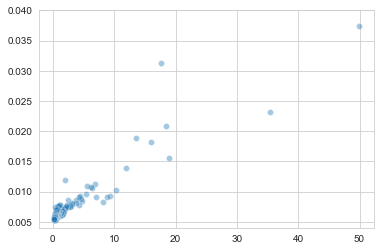

In [31]:
sns.scatterplot(x = eigen_vals[:p], y =bestRF.feature_importances_, alpha = .4)
plt.ylim(0.004,.04)

In [32]:
y_pred_new = newRF.predict(X_test_n)

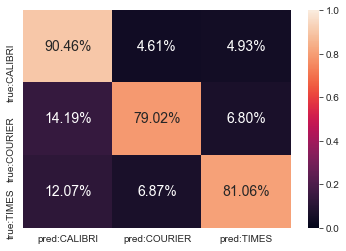

In [33]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test_n,y_pred = y_pred_new, labels = ['CALIBRI', 'COURIER', 'TIMES'], normalize = 'true'),
    index=['true:CALIBRI', 'true:COURIER', 'true:TIMES'], 
    columns=['pred:CALIBRI', 'pred:COURIER', 'pred:TIMES'])

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

# Question 5

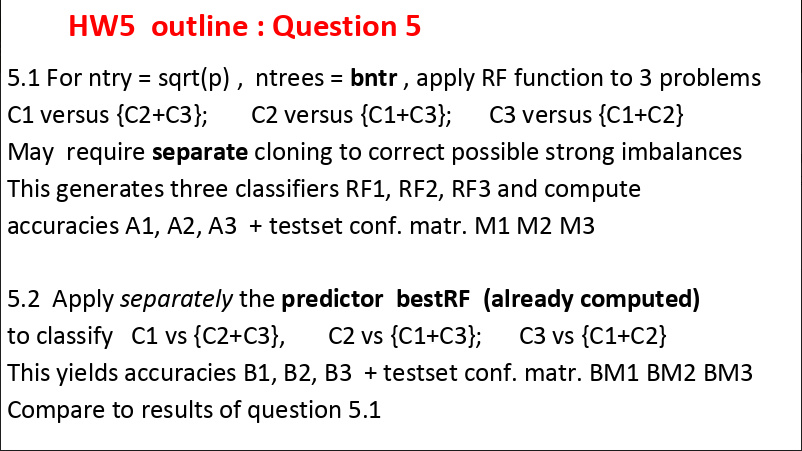

## 5.1

In [34]:
train = X_train.join(y_train)
test = X_test.join(y_test)

train['C1'] = np.where(train['font'] == 'CALIBRI', 'CALIBRI', 'COURIER or TIMES')
train['C2'] = np.where(train['font'] == 'COURIER', 'COURIER', 'CALIBRI or TIMES')
train['C3'] = np.where(train['font'] == 'TIMES', 'TIMES', 'CALIBRI or COURIER')

test['C1'] = np.where(test['font'] == 'CALIBRI', 'CALIBRI', 'COURIER or TIMES')
test['C2'] = np.where(test['font'] == 'COURIER', 'COURIER', 'CALIBRI or TIMES')
test['C3'] = np.where(test['font'] == 'TIMES', 'TIMES', 'CALIBRI or COURIER')

In [35]:
#1.3
X1_train = train.iloc[:,:127]
X1_test = test.iloc[:,:127]
y1_train = train['C1']
y1_test = test['C1']

#1.3
X2_train = train.iloc[:,:127]
X2_test = test.iloc[:,:127]
y2_train = train['C2']
y2_test = test['C2']

#1.3
X3_train = train.iloc[:,:127]
X3_test = test.iloc[:,:127]
y3_train = train['C3']
y3_test = test['C3']

In [36]:
ros = RandomOverSampler(random_state=0)

X1_res, y1_res = ros.fit_resample(X1_train, y1_train)
X2_res, y2_res = ros.fit_resample(X2_train, y2_train)
X3_res, y3_res = ros.fit_resample(X3_train, y3_train)

In [37]:
rf1 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf1.fit(X1_res, y1_res)
y1_pred_test = rf1.predict(X1_test)

rf2 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf2.fit(X2_res, y2_res)
y2_pred_test = rf2.predict(X2_test)

rf3 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf3.fit(X3_res, y3_res)
y3_pred_test = rf3.predict(X3_test)

In [38]:
a1 = accuracy_score(y1_test, y1_pred_test)
a2 = accuracy_score(y2_test, y2_pred_test)
a3 = accuracy_score(y3_test, y3_pred_test)

In [39]:
print(a1,a2,a3)

0.8988439306358381 0.8764450867052023 0.8757225433526011


In [40]:
ys_test = [y1_test, y2_test, y3_test]
ys_pred_test = [y1_pred_test, y2_pred_test, y3_pred_test]

In [41]:
cs=['C1','C2','C3']

In [42]:
print(ys_test[0].unique())
print(ys_test[1].unique())
print(ys_test[2].unique())

['CALIBRI' 'COURIER or TIMES']
['CALIBRI or TIMES' 'COURIER']
['CALIBRI or COURIER' 'TIMES']


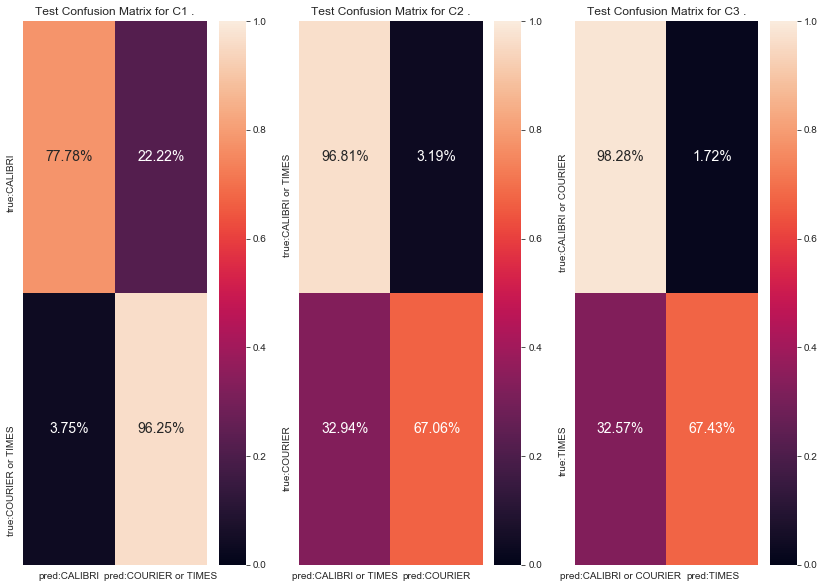

In [62]:
fig = plt.figure(figsize = (14,10))
axes = []

for i in range(0,len(ys_pred_test)):
    axes.append(fig.add_subplot(1, 3, i+1))
    
    cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=ys_test[i],y_pred = ys_pred_test[i], labels = ys_test[i].unique(), normalize = 'true'),
    index=['true:%s' % ys_test[i].unique()[0], 'true:%s' % ys_test[i].unique()[1]], 
    columns=['pred:%s' % ys_test[i].unique()[0], 'pred:%s' % ys_test[i].unique()[1]])
    
    sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1, ax=axes[i])
    axes[i].title.set_text('Test Confusion Matrix for '+str(cs[i])+' .')

In [63]:
ybest_df = pd.DataFrame(y_pred_best, columns = ['bestRF_pred'])
ybest_df['y_test'] = y_test.reset_index(drop = True)
ybest_df['best_predC1'] = np.where(ybest_df['bestRF_pred'] == 'CALIBRI', 'CALIBRI', 'COURIER or TIMES')
ybest_df['best_predC2'] = np.where(ybest_df['bestRF_pred'] == 'COURIER', 'COURIER', 'CALIBRI or TIMES')
ybest_df['best_predC3'] = np.where(ybest_df['bestRF_pred'] == 'TIMES', 'TIMES', 'CALIBRI or COURIER')
ybest_df['y_testC1'] = np.where(ybest_df['y_test'] == 'CALIBRI', 'CALIBRI', 'COURIER or TIMES')
ybest_df['y_testC2'] = np.where(ybest_df['y_test'] == 'COURIER', 'COURIER', 'CALIBRI or TIMES')
ybest_df['y_testC3'] = np.where(ybest_df['y_test'] == 'TIMES', 'TIMES', 'CALIBRI or COURIER')

In [64]:
ybest_df.head()

,bestRF_pred,y_test,best_predC1,best_predC2,best_predC3,y_testC1,y_testC2,y_testC3
0,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
1,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
2,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
3,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
4,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER


In [46]:
y_test.shape

(2768,)

In [47]:
b1 = accuracy_score(ybest_df['y_testC1'], ybest_df['best_predC1'])
b2 = accuracy_score(ybest_df['y_testC2'], ybest_df['best_predC2'])
b3 = accuracy_score(ybest_df['y_testC3'], ybest_df['best_predC3'])

In [48]:
print(b1,b2,b3)

0.8815028901734104 0.8898121387283237 0.891257225433526


In [49]:
bs=['BM1','BM2','BM3']

In [50]:
features = ['best_predC1', 'best_predC2', 'best_predC3', 'y_testC1', 'y_testC2', 'y_testC3']
ybest_df.head()

,bestRF_pred,y_test,best_predC1,best_predC2,best_predC3,y_testC1,y_testC2,y_testC3
0,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
1,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
2,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
3,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER
4,CALIBRI,CALIBRI,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER,CALIBRI,CALIBRI or TIMES,CALIBRI or COURIER


In [60]:
ys_test[2].unique()

array(['CALIBRI or COURIER', 'TIMES'], dtype=object)

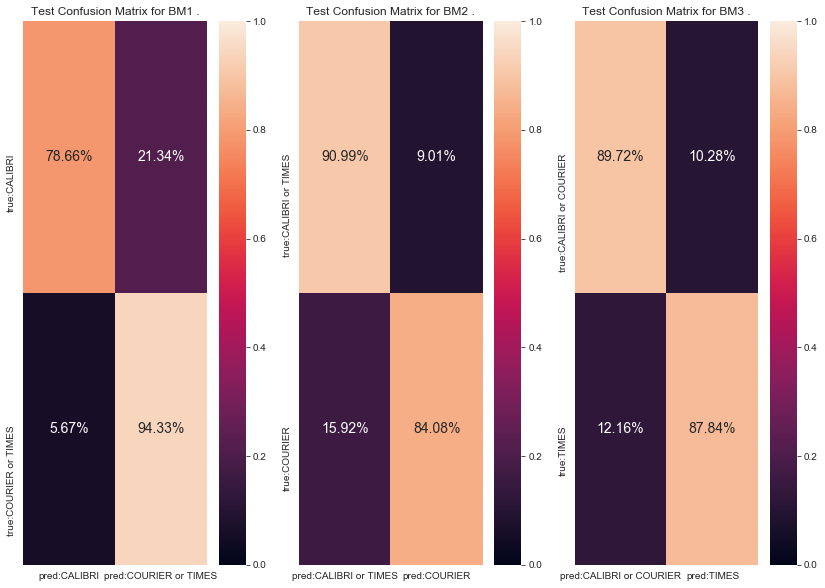

In [51]:
fig = plt.figure(figsize = (14,10))
axes = []

for i in range(0,3):
    axes.append(fig.add_subplot(1, 3, i+1))
    
    cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=ybest_df[features[i]],y_pred = ybest_df[features[i+3]], labels = ys_test[i].unique(), normalize = 'true'),
    index=['true:%s' % ys_test[i].unique()[0], 'true:%s' % ys_test[i].unique()[1]], 
    columns=['pred:%s' % ys_test[i].unique()[0], 'pred:%s' % ys_test[i].unique()[1]])
    
    sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1, ax=axes[i])
    axes[i].title.set_text('Test Confusion Matrix for '+str(bs[i])+' .')

In [ ]:
sm = SMOTE(random_state=0)

X1_smote, y1_smote = sm.fit_resample(X1_train, y1_train)
X2_smote, y2_smote = sm.fit_resample(X2_train, y2_train)
X3_smote, y3_smote = sm.fit_resample(X3_train, y3_train)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf1.fit(X1_smote, y1_smote)
y1_pred_test = rf1.predict(X1_test)

rf2 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf2.fit(X2_smote, y2_smote)
y2_pred_test = rf2.predict(X2_test)

rf3 = RandomForestClassifier(n_estimators=200, max_features= round(math.sqrt(p)), random_state=0)
rf3.fit(X3_smote, y3_smote)
y3_pred_test = rf3.predict(X3_test)

In [ ]:
a1 = accuracy_score(y1_test, y1_pred_test)
a2 = accuracy_score(y2_test, y2_pred_test)
a3 = accuracy_score(y3_test, y3_pred_test)

In [ ]:
print(a1,a2,a3)

In [ ]:
fig = plt.figure(figsize = (14,10))
axes = []

for i in range(0,len(ys_pred_test)):
    axes.append(fig.add_subplot(1, 3, i+1))
    
    cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=ys_test[i],y_pred = ys_pred_test[i], labels = ys_test[i].unique(), normalize = 'true'),
    index=['true:%s' % ys_test[i].unique()[0], 'true:%s' % ys_test[i].unique()[1]], 
    columns=['pred:%s' % ys_test[i].unique()[0], 'pred:%s' % ys_test[i].unique()[1]])
    
    sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1, ax=axes[i])
    axes[i].title.set_text('Test Confusion Matrix for '+str(cs[i])+' .')